In [99]:
import missingno         as msno
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import warnings
import copy
import os
import glob
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
from scipy import stats

%matplotlib inline

In [100]:
#from google.colab import drive
#drive.mount('/content/drive')

In [101]:
# libraries for Linear regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from statsmodels.api import OLS

In [102]:
# libraries for NN
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import load_model
import keras.backend as K


In [110]:
#PyDirectory = r'drive/Shareddrives/DS4W-Team/NN'
#OutDirectory = PyDirectory+"/Results"
#if not os.path.exists(OutDirectory):
#    os.mkdir(OutDirectory)
    
PyDirectory = '/Users/laurashelley/Documents/ds4a/capstone/code/NN'#/Documents/ds4a/capstone/code/NN'
OutDirectory = PyDirectory+"/Results"
if not os.path.exists(OutDirectory):
    os.mkdir(OutDirectory)

In [104]:
# read cleaned data
#train_median_pop = pd.read_csv('drive/Shareddrives/DS4W-Team/Data/train_median_pop.csv', delimiter=',')
train_median_pop = pd.read_csv('/Users/laurashelley/Documents/ds4a/capstone/code/NN/train_median_pop.csv')

In [105]:
# Transform categorical variables to dummies

# train_median_pop['Year_Factor'] = train_median_pop['Year_Factor'].astype('object')   -> this line is commented so Year_Factor is kept as a numeric feature

Categorical_features = train_median_pop.select_dtypes(include='object').columns.to_list()
Numerical_features = train_median_pop.select_dtypes(include='number').columns.to_list()

print('Categorical Features:', Categorical_features, '\n')
print('Numerical Features:', Numerical_features)
x_cat = train_median_pop[Categorical_features]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x_cat)

x_cat_arr = enc.transform(x_cat).toarray()

x_cat_df = pd.DataFrame(x_cat_arr, columns = enc.get_feature_names(Categorical_features))
x_cat_df
train_median_pop = pd.concat([train_median_pop, x_cat_df], axis = 1).drop(Categorical_features, axis = 1)
train_median_pop

Categorical Features: ['State_Factor', 'building_class', 'facility_type'] 

Numerical Features: ['Year_Factor', 'year_built', 'energy_star_rating', 'ELEVATION', 'cooling_degree_days', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F', 'days_above_110F', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog', 'site_eui', '1_min', '2_min', '3_min', '1_avg', '2_avg', '3_avg', '1_max', '2_max', '3_max', '1_span', '2_span', '3_span', 'floor_area_log']


,Year_Factor,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,1_min,2_min,3_min,1_avg,2_avg,3_avg,1_max,2_max,3_max,1_span,2_span,3_span,floor_area_log,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_2to4_Unit_Building,facility_type_5plus_Unit_Building,facility_type_Commercial_Other,facility_type_Commercial_Unknown,facility_type_Data_Center,...,facility_type_Food_Service_Other,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,104.0,248.682615,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,11.022589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,26.500150,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.520883,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,24.693619,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.542634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [111]:
# Normalizing the data (feature scaling)

x = train_median_pop.loc[:, train_median_pop.columns != 'site_eui']
y = train_median_pop['site_eui']

scaler = StandardScaler()
scaler_x = scaler.fit(x)
x_n = scaler_x.fit_transform(x)
scaler_y = scaler.fit(pd.DataFrame(y))
y_n = scaler_y.fit_transform(pd.DataFrame(y))

print(x_n.shape,y_n.shape)

(75757, 104) (75757, 1)


<AxesSubplot:>

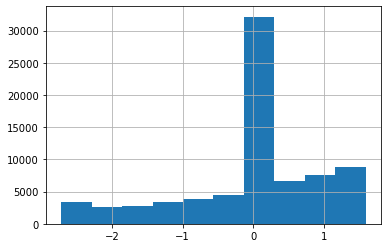

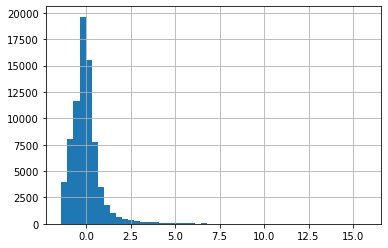

In [112]:
# see e*_scaled & site_eui_scaled:
x_n_df = pd.DataFrame(x_n, index=x.index, columns=x.columns)
x_n_df['energy_star_rating'].hist()

y_n_df = pd.DataFrame(y_n, index=pd.DataFrame(y).index, columns=pd.DataFrame(y).columns)
plt.figure()
y_n_df['site_eui'].hist(bins=50)

In [113]:
# split data to train data and test data
X_train , X_test, Y_train , Y_test = train_test_split(x_n , y_n, test_size=0.1, random_state=17)
print(X_train.shape,X_test.shape)


(68181, 104) (7576, 104)


In [114]:
# compile a NN with 4 hidden layers, each 20 neurons
model_NN = Sequential()
n_cols = X_train.shape[1]
print(n_cols)
model_NN.add(Dense(20,activation='relu',input_shape=(n_cols,)))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(1))
#optimizer = keras.optimizer_v2.adam.Adam(0.001)
optimizer = 'adam'
model_NN.compile(optimizer=optimizer,loss='mean_squared_error')


104


# 1_full batch training

In [115]:
# load weights if the model is ran previously
weightsdir='/weights_1'
if not os.path.exists(OutDirectory+weightsdir):
    os.mkdir(OutDirectory+weightsdir)
txt= glob.glob(OutDirectory+weightsdir+'/best.h5')
VOld=len(txt)
VNew=len(txt)+1
print('modelinv old=',VOld)
if VOld!=0:
    model_NN.load_weights(OutDirectory+weightsdir+'/best.h5')
    trained_inv=1
else:
    trained_inv=0

# weightsdir='/weights_1'
# if not os.path.exists(OutDirectory+weightsdir):
#     os.mkdir(OutDirectory+weightsdir)
# tr_best_end = 'best'  #'best' or 'end'
# txt= glob.glob(OutDirectory+weightsdir+'/*-{}.h5'.format(tr_best_end))
# VOld=len(txt)
# VNew=len(txt)+1
# print('model_old=',VOld)
# print('model_new=',VNew)
# if VOld!=0:
#     model_NN.load_weights(OutDirectory+weightsdir+'/{}-{}.h5'.format(VOld,tr_best_end))
#     trained=1
# else:
#     trained=0
# print('trained=',trained)    

modelinv old= 0


In [116]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=200),
    tf.keras.callbacks.ModelCheckpoint(filepath=OutDirectory+weightsdir+'/best.h5',#.{epoch:02d}-{loss:.2f}.h5',
                                             verbose=0, monitor='loss', save_best_only=True,
                                             save_weights_only=True,),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [117]:
# train NN using full batch 
# h = model_NN.fit(X_train,Y_train,batch_size=70000,epochs=1000,callbacks=my_callbacks)
#h = model_NN.fit(X_train,Y_train,batch_size=70,epochs=100,callbacks=my_callbacks)
h = model_NN.fit(X_train,Y_train,epochs=100,callbacks=my_callbacks) #full batch

Epoch 1/100
68181/68181 [==============================] - 3s 42us/step - loss: 0.6825
Epoch 2/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.6169
Epoch 3/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.6033
Epoch 4/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5952
Epoch 5/100
68181/68181 [==============================] - 2s 35us/step - loss: 0.5863
Epoch 6/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5789
Epoch 7/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5726
Epoch 8/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5688
Epoch 9/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5642
Epoch 10/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5572
Epoch 11/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5541
Epoch 12/100
68181/68181 [===============

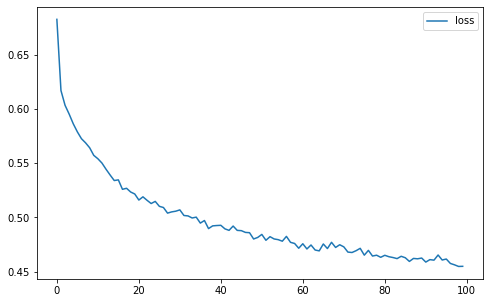

In [118]:
# plot loss evolution
pd.DataFrame(h.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

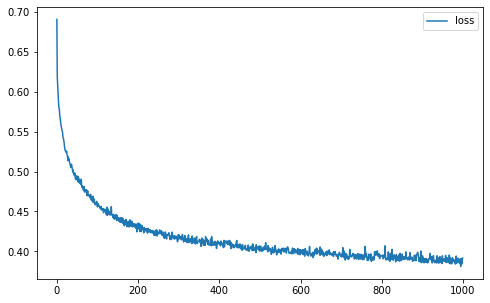

In [36]:
# plot loss evolution
pd.DataFrame(h.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

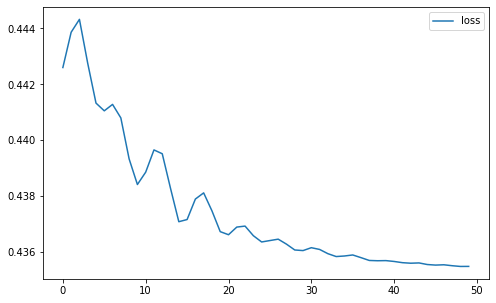

In [19]:
# plot loss evolution
pd.DataFrame(h.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()


In [119]:
model_NN.save(OutDirectory+weightsdir+'/model.h5')

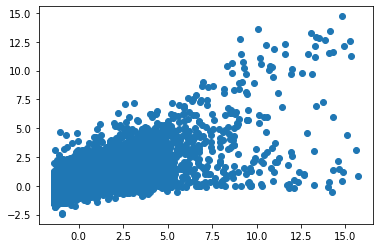

In [133]:
Y_train_pred = model_NN.predict(X_train)
plt.scatter(Y_train,Y_train_pred)

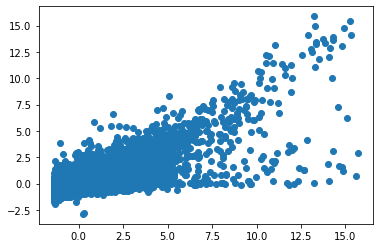

In [38]:
Y_train_pred = model_NN.predict(X_train)
plt.scatter(Y_train,Y_train_pred)

In [ ]:
# When have big data, training is faster if split data into mini batches, rather than full batch
# remove outlier?
# use LSTM? 
# drop year_factor ??
# dependent on time-series? 
# scale then split or split then scale? 
# cleaned data

Train again - drop year factor

In [120]:
df = train_median_pop.drop('Year_Factor', axis = 1)

In [139]:
train_median_pop.head()

,Year_Factor,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,1_min,2_min,3_min,1_avg,2_avg,3_avg,1_max,2_max,3_max,1_span,2_span,3_span,floor_area_log,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_2to4_Unit_Building,facility_type_5plus_Unit_Building,facility_type_Commercial_Other,facility_type_Commercial_Unknown,facility_type_Data_Center,...,facility_type_Food_Service_Other,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,104.0,248.682615,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,11.022589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,26.500150,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.520883,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,24.693619,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.542634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [121]:
df.head()


,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,1_min,2_min,3_min,1_avg,2_avg,3_avg,1_max,2_max,3_max,1_span,2_span,3_span,floor_area_log,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_2to4_Unit_Building,facility_type_5plus_Unit_Building,facility_type_Commercial_Other,facility_type_Commercial_Unknown,facility_type_Data_Center,facility_type_Education_College_or_university,...,facility_type_Food_Service_Other,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,104.0,248.682615,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,11.022589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,26.500150,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.520883,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,24.693619,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.542634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [122]:
x2 = df.loc[:, df.columns != 'site_eui']
y2 = df['site_eui']

scaler = StandardScaler()
scaler_x2 = scaler.fit(x2)
x_n2 = scaler_x2.fit_transform(x2)
scaler_y2 = scaler.fit(pd.DataFrame(y2))
y_n2 = scaler_y2.fit_transform(pd.DataFrame(y2))

print(x_n2.shape,y_n2.shape)

(75757, 103) (75757, 1)


In [123]:
X_train2 , X_test2, Y_train2 , Y_test2 = train_test_split(x_n2 , y_n2, test_size=0.1, random_state=17)
print(X_train2.shape,X_test2.shape)

(68181, 103) (7576, 103)


In [124]:
# compile a NN with 4 hidden layers, each 20 neurons
model_NN2 = Sequential()
n_cols2 = X_train2.shape[1]
print(n_cols2)
model_NN2.add(Dense(20,activation='relu',input_shape=(n_cols2,)))
model_NN2.add(Dense(20,activation='relu'))
model_NN2.add(Dense(20,activation='relu'))
model_NN2.add(Dense(20,activation='relu'))
model_NN2.add(Dense(1))
#optimizer = keras.optimizer_v2.adam.Adam(0.001)
optimizer = 'adam'
model_NN2.compile(optimizer=optimizer,loss='mean_squared_error')

103


In [125]:
#h = model_NN.fit(X_train,Y_train,epochs=100,callbacks=my_callbacks) #full batch
h2 = model_NN2.fit(X_train2,Y_train2,epochs=100) #full batch

Epoch 1/100
68181/68181 [==============================] - 3s 43us/step - loss: 0.6830
Epoch 2/100
68181/68181 [==============================] - 3s 37us/step - loss: 0.6169
Epoch 3/100
68181/68181 [==============================] - 3s 37us/step - loss: 0.6024
Epoch 4/100
68181/68181 [==============================] - 2s 37us/step - loss: 0.5955
Epoch 5/100
68181/68181 [==============================] - 2s 37us/step - loss: 0.5870
Epoch 6/100
68181/68181 [==============================] - 3s 37us/step - loss: 0.5797
Epoch 7/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5743
Epoch 8/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5689
Epoch 9/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5635
Epoch 10/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5619
Epoch 11/100
68181/68181 [==============================] - 2s 36us/step - loss: 0.5568
Epoch 12/100
68181/68181 [===============

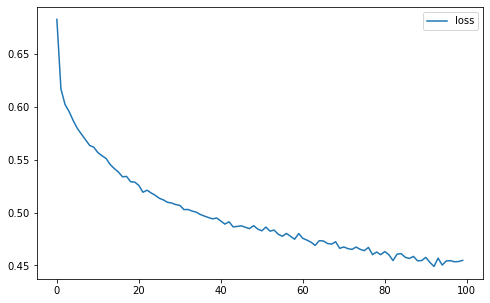

In [126]:
# plot loss evolution
pd.DataFrame(h2.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

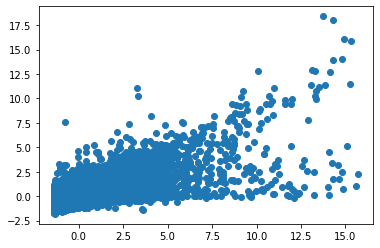

In [127]:
#using MSE and dropped year_factor
Y_train_pred2 = model_NN2.predict(X_train2)
plt.scatter(Y_train2,Y_train_pred2)

train again - with with mean absolute error instead - also year factor dropped

In [128]:
model_NN3 = Sequential()
n_cols2 = X_train2.shape[1]
print(n_cols2)
model_NN3.add(Dense(20,activation='relu',input_shape=(n_cols2,)))
model_NN3.add(Dense(20,activation='relu'))
model_NN3.add(Dense(20,activation='relu'))
model_NN3.add(Dense(20,activation='relu'))
model_NN3.add(Dense(1))
#optimizer = keras.optimizer_v2.adam.Adam(0.001)
optimizer = 'adam'
model_NN3.compile(optimizer=optimizer,loss='mean_absolute_error')

103


In [129]:
h3 = model_NN3.fit(X_train2,Y_train2,epochs=100) #full batch

Epoch 1/100
68181/68181 [==============================] - 3s 40us/step - loss: 0.4106
Epoch 2/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3858
Epoch 3/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3814
Epoch 4/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3775
Epoch 5/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3753
Epoch 6/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3737
Epoch 7/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3719
Epoch 8/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3703
Epoch 9/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3690
Epoch 10/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3684
Epoch 11/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.3675
Epoch 12/100
68181/68181 [===============

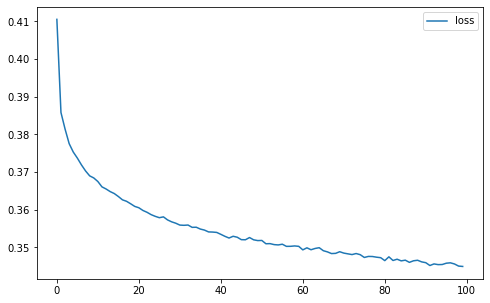

In [130]:
# plot loss evolution
pd.DataFrame(h3.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

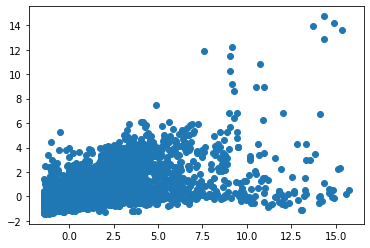

In [132]:
#using MAE and dropped year_factor
Y_train_pred3 = model_NN3.predict(X_train2)
plt.scatter(Y_train2,Y_train_pred3)

Run again with a dataset taking out vars with missings (and take out year_factor) (and use MAE)

In [158]:
miss = {'days_with_fog', 'direction_peak_wind_speed', 'max_wind_speed',
        'direction_max_wind_speed', 'energy_star_rating'}

train_nomissingsvars = train_median_pop.drop([
    'Year_Factor', 'days_with_fog', 'direction_peak_wind_speed',
    'max_wind_speed', 'direction_max_wind_speed', 'energy_star_rating'], axis = 1)

train_nomissingsvars.head()

,year_built,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui,1_min,2_min,3_min,1_avg,2_avg,3_avg,1_max,2_max,3_max,1_span,2_span,3_span,floor_area_log,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_2to4_Unit_Building,facility_type_5plus_Unit_Building,facility_type_Commercial_Other,facility_type_Commercial_Unknown,facility_type_Data_Center,facility_type_Education_College_or_university,facility_type_Education_Other_classroom,facility_type_Education_Preschool_or_daycare,facility_type_Education_Uncategorized,facility_type_Food_Sales,facility_type_Food_Service_Other,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1942.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,248.682615,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,11.022589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1955.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,26.500150,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.520883,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1951.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,24.693619,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.542634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [160]:
train_nomissingsvars.shape

(75757, 99)

In [162]:
xnm = train_nomissingsvars.loc[:, train_nomissingsvars.columns != 'site_eui']
ynm = train_nomissingsvars['site_eui']

scaler = StandardScaler()
scaler_xnm = scaler.fit(xnm)
x_nm = scaler_xnm.fit_transform(xnm)
scaler_ynm = scaler.fit(pd.DataFrame(ynm))
y_nm = scaler_ynm.fit_transform(pd.DataFrame(ynm))

print(x_nm.shape,y_nm.shape)

(75757, 98) (75757, 1)


In [163]:
X_trainnm , X_testnm, Y_trainnm, Y_testnm = train_test_split(x_nm , y_nm, test_size=0.1, random_state=17)
print(X_trainnm.shape,X_testnm.shape)

(68181, 98) (7576, 98)


In [164]:
# compile a NN with 4 hidden layers, each 20 neurons
model_NN_nm = Sequential()
n_colsnm = X_trainnm.shape[1]
print(n_colsnm)
model_NN_nm.add(Dense(20,activation='relu',input_shape=(n_colsnm,)))
model_NN_nm.add(Dense(20,activation='relu'))
model_NN_nm.add(Dense(20,activation='relu'))
model_NN_nm.add(Dense(20,activation='relu'))
model_NN_nm.add(Dense(1))
#optimizer = keras.optimizer_v2.adam.Adam(0.001)
optimizer = 'adam'
model_NN_nm.compile(optimizer=optimizer,loss='mean_absolute_error')

98


In [165]:
h_nm = model_NN_nm.fit(X_trainnm,Y_trainnm,epochs=100) #full batch

Epoch 1/100
68181/68181 [==============================] - 3s 40us/step - loss: 0.4798
Epoch 2/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.4627
Epoch 3/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.4592
Epoch 4/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.4567
Epoch 5/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.4548
Epoch 6/100
68181/68181 [==============================] - 2s 34us/step - loss: 0.4536
Epoch 7/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.4524
Epoch 8/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.4519
Epoch 9/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.4511
Epoch 10/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.4500
Epoch 11/100
68181/68181 [==============================] - 2s 33us/step - loss: 0.4494
Epoch 12/100
68181/68181 [===============

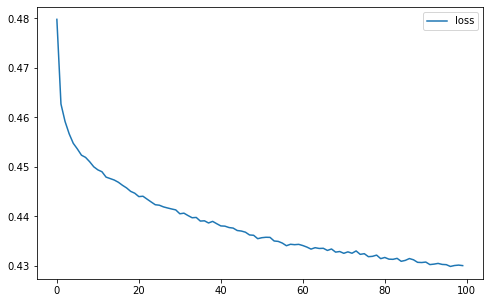

In [166]:
# plot loss evolution
pd.DataFrame(h_nm.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

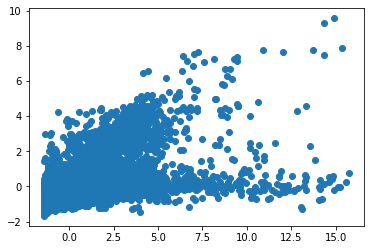

In [167]:
#without vars with missings; using MAE; and dropped year_factor
Y_train_pred_nm = model_NN_nm.predict(X_trainnm)
plt.scatter(Y_trainnm,Y_train_pred_nm)

pull different imputation methods - separate datasets

In [313]:
train = pd.read_csv('/Users/laurashelley/Documents/ds4a/capstone/code/data/train.csv')


In [314]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [315]:
#Log transformation of floor_area

train['floor_area'] = np.log(train['floor_area'])

In [316]:
#add a temp_year_span variable (max temp in year - min temp in year)
train['temp_year_span'] = max(train.iloc[:, 8:44].max()) - min(train.iloc[:, 8:44].min())


In [317]:
#transform categorical vars into dummies
# Transform categorical variables to dummies

# train_median_pop['Year_Factor'] = train_median_pop['Year_Factor'].astype('object')   -> this line is commented so Year_Factor is kept as a numeric feature

Categorical_features = train.select_dtypes(include='object').columns.to_list()
Numerical_features = train.select_dtypes(include='number').columns.to_list()

print('Categorical Features:', Categorical_features, '\n')
print('Numerical Features:', Numerical_features)
x_cat = train[Categorical_features]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x_cat)

x_cat_arr = enc.transform(x_cat).toarray()

x_cat_df = pd.DataFrame(x_cat_arr, columns = enc.get_feature_names(Categorical_features))
x_cat_df
train = pd.concat([train, x_cat_df], axis = 1).drop(Categorical_features, axis = 1)
train

Categorical Features: ['State_Factor', 'building_class', 'facility_type'] 

Numerical Features: ['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp', 'february_min_temp', 'february_avg_temp', 'february_max_temp', 'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp', 'august_max_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'october_min_temp', 'october_avg_temp', 'october_max_temp', 'november_min_temp', 'november_avg_temp', 'november_max_temp', 'december_min_temp', 'december_avg_temp', 'december_max_temp', 'cooling_degree_days', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'avg_temp', 'days_below_30

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,...,facility_type_Food_Service_Other,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1,11.022589,1942.0,11.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,12.520883,1955.0,45.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,12.542634,1951.0,97.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0

In [318]:
train.shape

(75757, 131)

In [319]:
#transform year built into age variable
train['year_built'] = np.where((train.year_built==0) | (np.isnan(train.year_built)), train.year_built.mode(), train.year_built)
train['age'] = 2022 - train['year_built']
train.drop('year_built', axis = 1, inplace = True)

In [320]:
missing_features = ['days_with_fog', 'direction_peak_wind_speed', 'max_wind_speed',
                    'direction_max_wind_speed', 'energy_star_rating']
train[missing_features].describe()

,days_with_fog,direction_peak_wind_speed,max_wind_speed,direction_max_wind_speed,energy_star_rating
count,29961.000000,33946.000000,34675.000000,34675.000000,49048.000000
mean,109.142051,62.779974,4.190601,66.552675,61.048605
std,50.699751,130.308106,6.458789,131.147834,28.663683
min,12.000000,1.000000,1.000000,1.000000,0.000000
25%,88.000000,1.000000,1.000000,1.000000,40.000000
50%,104.000000,1.000000,1.000000,1.000000,67.000000
75%,131.000000,1.000000,1.000000,1.000000,85.000000
max,311.000000,360.000000,23.300000,360.000000,100.000000


In [321]:
#fill wind-related vars with pop mean, the rest with median
train_wind_mean_pop = copy.deepcopy(train)
for i in range(1, len(missing_features) - 1):
    train_wind_mean_pop[missing_features[i]].fillna(train_wind_mean_pop[missing_features[i]].mean(), inplace = True)
    
train_wind_mean_pop['energy_star_rating'].fillna(train_wind_mean_pop['energy_star_rating'].median(), inplace = True)
train_wind_mean_pop['days_with_fog'].fillna(train_wind_mean_pop['days_with_fog'].median(), inplace = True)



In [322]:
#fill days with fog with mode, all else with median
train_fog_mode_pop = copy.deepcopy(train)
for i in range(1, len(missing_features)):
    train_fog_mode_pop[missing_features[i]].fillna(train_fog_mode_pop[missing_features[i]].median(), inplace = True)


In [323]:
train_fog_mode_pop['days_with_fog'].mode()

0    131.0
dtype: float64

In [324]:
train_fog_mode_pop['days_with_fog'].fillna(131, inplace = True)

In [325]:
#fill energy star rating with mean, all else with median
train_star_mean_pop = copy.deepcopy(train)
for i in range(len(missing_features) - 1):
    train_star_mean_pop[missing_features[i]].fillna(train_star_mean_pop[missing_features[i]].median(), inplace = True)
    
train_star_mean_pop['energy_star_rating'].fillna(train_star_mean_pop['energy_star_rating'].mean(), inplace = True)    


In [326]:
## can also try subgroup medians in yi on's code, but start with the above for now

Run NN on dataset with wind-related vars = mean; rest = median

In [327]:
train_wind_mean_pop.drop('Year_Factor', axis = 1, inplace=True)
train_wind_mean_pop.head()

,floor_area,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,...,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized,age
0,11.022589,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
1,12.520883,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,67.0
2,12.542634,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [328]:
train_wind_mean_pop

# Normalizing the data (feature scaling)

x = train_wind_mean_pop.loc[:, train_wind_mean_pop.columns != 'site_eui']
y = train_wind_mean_pop['site_eui']

scaler = StandardScaler()
scaler_x = scaler.fit(x)
x_n = scaler_x.fit_transform(x)
scaler_y = scaler.fit(pd.DataFrame(y))
y_n = scaler_y.fit_transform(pd.DataFrame(y))

print(x_n.shape,y_n.shape)

(75757, 129) (75757, 1)


In [329]:
# split data to train data and test data
X_train , X_test, Y_train , Y_test = train_test_split(x_n , y_n, test_size=0.1, random_state=17)
print(X_train.shape,X_test.shape)

(68181, 129) (7576, 129)


In [330]:
# compile a NN with 4 hidden layers, each 20 neurons
model_NN = Sequential()
n_cols = X_train.shape[1]
print(n_cols)
model_NN.add(Dense(20,activation='relu',input_shape=(n_cols,)))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(1))
#optimizer = keras.optimizer_v2.adam.Adam(0.001)
optimizer = 'adam'
model_NN.compile(optimizer=optimizer,loss='mean_absolute_error')

129


###### something is wrong here, where are there 130 columns? should be like 104
### what's different from train_median_pop?

In [331]:
h101 = model_NN.fit(X_train,Y_train,epochs=100) #full batch

Epoch 1/100
68181/68181 [==============================] - 5s 69us/step - loss: 0.4172
Epoch 2/100
68181/68181 [==============================] - 4s 63us/step - loss: 0.3883
Epoch 3/100
68181/68181 [==============================] - 4s 62us/step - loss: 0.3828
Epoch 4/100
68181/68181 [==============================] - 4s 61us/step - loss: 0.3800
Epoch 5/100
68181/68181 [==============================] - 4s 61us/step - loss: 0.3767
Epoch 6/100
68181/68181 [==============================] - 4s 61us/step - loss: 0.3743
Epoch 7/100
68181/68181 [==============================] - 4s 61us/step - loss: 0.3730
Epoch 8/100
68181/68181 [==============================] - 4s 61us/step - loss: 0.3716
Epoch 9/100
68181/68181 [==============================] - 4s 63us/step - loss: 0.3701
Epoch 10/100
68181/68181 [==============================] - 4s 63us/step - loss: 0.3682
Epoch 11/100
68181/68181 [==============================] - 4s 63us/step - loss: 0.3674
Epoch 12/100
68181/68181 [===============

68181/68181 [==============================] - 4s 62us/step - loss: 0.3454
Epoch 95/100
68181/68181 [==============================] - 4s 62us/step - loss: 0.3452
Epoch 96/100
68181/68181 [==============================] - 4s 63us/step - loss: 0.3454
Epoch 97/100
68181/68181 [==============================] - 4s 62us/step - loss: 0.3454
Epoch 98/100
68181/68181 [==============================] - 4s 61us/step - loss: 0.3450
Epoch 99/100
68181/68181 [==============================] - 4s 62us/step - loss: 0.3451
Epoch 100/100
68181/68181 [==============================] - 4s 62us/step - loss: 0.3450


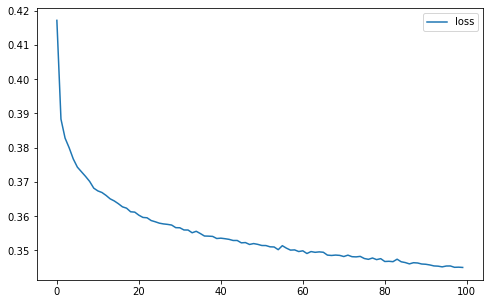

In [332]:
# plot loss evolution
pd.DataFrame(h101.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

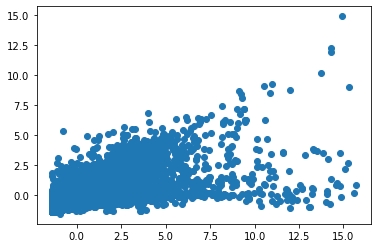

In [333]:
#wind-related vars = mean; rest = median; 
Y_train_pred = model_NN.predict(X_train)
plt.scatter(Y_train,Y_train_pred)

Run NN on dataset with fog = mode; rest = median

In [334]:
train_fog_mode_pop.drop('Year_Factor', axis = 1, inplace=True)
train_fog_mode_pop.head()

,floor_area,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,...,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized,age
0,11.022589,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
1,12.520883,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,67.0
2,12.542634,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [335]:
# Normalizing the data (feature scaling)

x = train_fog_mode_pop.loc[:, train_fog_mode_pop.columns != 'site_eui']
y = train_fog_mode_pop['site_eui']

scaler = StandardScaler()
scaler_x = scaler.fit(x)
x_n = scaler_x.fit_transform(x)
scaler_y = scaler.fit(pd.DataFrame(y))
y_n = scaler_y.fit_transform(pd.DataFrame(y))

print(x_n.shape,y_n.shape)

(75757, 129) (75757, 1)


In [336]:
# split data to train data and test data
X_train , X_test, Y_train , Y_test = train_test_split(x_n , y_n, test_size=0.1, random_state=17)
print(X_train.shape,X_test.shape)

(68181, 129) (7576, 129)


In [337]:
# compile a NN with 4 hidden layers, each 20 neurons
model_NN = Sequential()
n_cols = X_train.shape[1]
print(n_cols)
model_NN.add(Dense(20,activation='relu',input_shape=(n_cols,)))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(1))
#optimizer = keras.optimizer_v2.adam.Adam(0.001)
optimizer = 'adam'
model_NN.compile(optimizer=optimizer,loss='mean_absolute_error')

129


In [338]:
h102 = model_NN.fit(X_train,Y_train,epochs=100) #full batch

Epoch 1/100
68181/68181 [==============================] - 4s 62us/step - loss: 0.4171
Epoch 2/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3875
Epoch 3/100
68181/68181 [==============================] - 4s 60us/step - loss: 0.3825
Epoch 4/100
68181/68181 [==============================] - 4s 56us/step - loss: 0.3791
Epoch 5/100
68181/68181 [==============================] - 4s 56us/step - loss: 0.3761
Epoch 6/100
68181/68181 [==============================] - 4s 60us/step - loss: 0.3739
Epoch 7/100
68181/68181 [==============================] - 4s 63us/step - loss: 0.3725
Epoch 8/100
68181/68181 [==============================] - 4s 56us/step - loss: 0.3712
Epoch 9/100
68181/68181 [==============================] - 4s 56us/step - loss: 0.3700
Epoch 10/100
68181/68181 [==============================] - 4s 55us/step - loss: 0.3689
Epoch 11/100
68181/68181 [==============================] - 4s 55us/step - loss: 0.3683
Epoch 12/100
68181/68181 [===============

68181/68181 [==============================] - 4s 55us/step - loss: 0.3482
Epoch 95/100
68181/68181 [==============================] - 4s 55us/step - loss: 0.3482
Epoch 96/100
68181/68181 [==============================] - 4s 55us/step - loss: 0.3479
Epoch 97/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3476
Epoch 98/100
68181/68181 [==============================] - 4s 55us/step - loss: 0.3482
Epoch 99/100
68181/68181 [==============================] - 4s 58us/step - loss: 0.3475
Epoch 100/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3474


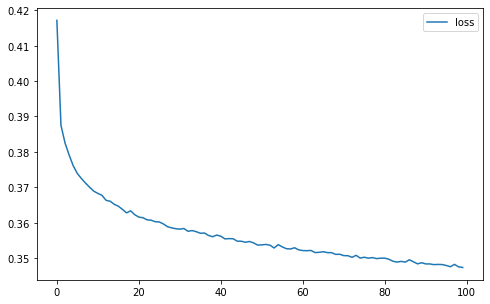

In [339]:
# plot loss evolution
pd.DataFrame(h102.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

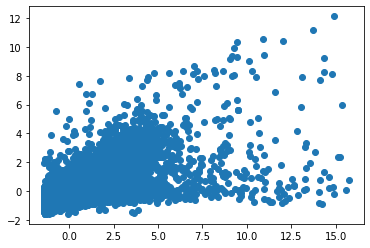

In [340]:
#fog = mode; rest = median
Y_train_pred = model_NN.predict(X_train)
plt.scatter(Y_train,Y_train_pred)

energy star rating = mean; rest = median

In [341]:
train_star_mean_pop.drop('Year_Factor', axis = 1, inplace=True)
train_star_mean_pop.head()

,floor_area,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,...,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized,age
0,11.022589,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
1,12.520883,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,67.0
2,12.542634,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [342]:
# Normalizing the data (feature scaling)

x = train_star_mean_pop.loc[:, train_star_mean_pop.columns != 'site_eui']
y = train_star_mean_pop['site_eui']

scaler = StandardScaler()
scaler_x = scaler.fit(x)
x_n = scaler_x.fit_transform(x)
scaler_y = scaler.fit(pd.DataFrame(y))
y_n = scaler_y.fit_transform(pd.DataFrame(y))

print(x_n.shape,y_n.shape)

(75757, 129) (75757, 1)


In [343]:
# split data to train data and test data
X_train , X_test, Y_train , Y_test = train_test_split(x_n , y_n, test_size=0.1, random_state=17)
print(X_train.shape,X_test.shape)

(68181, 129) (7576, 129)


In [344]:
# compile a NN with 4 hidden layers, each 20 neurons
model_NN = Sequential()
n_cols = X_train.shape[1]
print(n_cols)
model_NN.add(Dense(20,activation='relu',input_shape=(n_cols,)))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(1))
#optimizer = keras.optimizer_v2.adam.Adam(0.001)
optimizer = 'adam'
model_NN.compile(optimizer=optimizer,loss='mean_absolute_error')

129


In [345]:
h103 = model_NN.fit(X_train,Y_train,epochs=100) #full batch

Epoch 1/100
68181/68181 [==============================] - 5s 67us/step - loss: 0.4160
Epoch 2/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3873
Epoch 3/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3822
Epoch 4/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3783
Epoch 5/100
68181/68181 [==============================] - 4s 56us/step - loss: 0.3761
Epoch 6/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3736
Epoch 7/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3726
Epoch 8/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3703
Epoch 9/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3693
Epoch 10/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3679
Epoch 11/100
68181/68181 [==============================] - 4s 57us/step - loss: 0.3678
Epoch 12/100
68181/68181 [===============

68181/68181 [==============================] - 4s 55us/step - loss: 0.3463
Epoch 95/100
68181/68181 [==============================] - 4s 56us/step - loss: 0.3466
Epoch 96/100
68181/68181 [==============================] - 4s 55us/step - loss: 0.3464
Epoch 97/100
68181/68181 [==============================] - 4s 54us/step - loss: 0.3467
Epoch 98/100
68181/68181 [==============================] - 4s 54us/step - loss: 0.3457
Epoch 99/100
68181/68181 [==============================] - 4s 55us/step - loss: 0.3467
Epoch 100/100
68181/68181 [==============================] - 4s 54us/step - loss: 0.3460


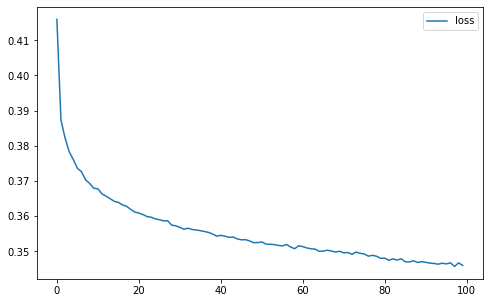

In [346]:
# plot loss evolution
pd.DataFrame(h103.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

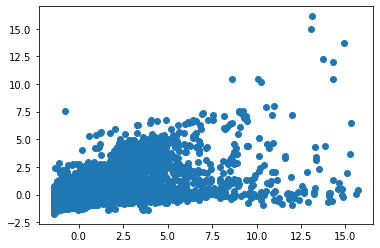

In [347]:
#fog = mode; rest = median
Y_train_pred = model_NN.predict(X_train)
plt.scatter(Y_train,Y_train_pred)

In [229]:
tmpwind = list(train_wind_mean_pop)
tmpmed = list(train_median_pop)
list(set(tmpwind).symmetric_difference(set(tmpmed)))

['march_avg_temp',
 'january_max_temp',
 '3_min',
 'Year_Factor',
 'june_min_temp',
 '2_max',
 'age',
 'april_min_temp',
 '1_max',
 '3_max',
 'may_avg_temp',
 'april_max_temp',
 'august_min_temp',
 'february_min_temp',
 'december_min_temp',
 'january_avg_temp',
 'id',
 'september_max_temp',
 '1_min',
 'may_max_temp',
 'september_avg_temp',
 'october_avg_temp',
 'february_avg_temp',
 'floor_area',
 '3_avg',
 'november_max_temp',
 'july_max_temp',
 'november_min_temp',
 'march_max_temp',
 'november_avg_temp',
 '3_span',
 '1_span',
 'march_min_temp',
 'february_max_temp',
 '2_avg',
 'april_avg_temp',
 'year_built',
 '2_min',
 'temp_year_span',
 'july_avg_temp',
 'june_max_temp',
 'august_max_temp',
 'december_avg_temp',
 'may_min_temp',
 'august_avg_temp',
 'floor_area_log',
 'october_max_temp',
 'december_max_temp',
 'june_avg_temp',
 'january_min_temp',
 'july_min_temp',
 '2_span',
 'october_min_temp',
 'september_min_temp',
 '1_avg']

In [217]:
train_median_pop.head()

,Year_Factor,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,1_min,2_min,3_min,1_avg,2_avg,3_avg,1_max,2_max,3_max,1_span,2_span,3_span,floor_area_log,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_2to4_Unit_Building,facility_type_5plus_Unit_Building,facility_type_Commercial_Other,facility_type_Commercial_Unknown,facility_type_Data_Center,...,facility_type_Food_Service_Other,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,104.0,248.682615,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,11.022589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,26.500150,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.520883,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,24.693619,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.542634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Try removing outliers -d ['site_eui', 'ELEVATION']

simple 3SDs away - just to see 
(after that try log transforming? worked for floor_area)

In [348]:
df = pd.read_csv('/Users/laurashelley/Documents/ds4a/capstone/code/NN/train_median_pop.csv')
df.describe()
df.shape


(75757, 39)

In [349]:
# Transform categorical variables to dummies

# train_median_pop['Year_Factor'] = train_median_pop['Year_Factor'].astype('object')   -> this line is commented so Year_Factor is kept as a numeric feature

Categorical_features = df.select_dtypes(include='object').columns.to_list()
Numerical_features = df.select_dtypes(include='number').columns.to_list()

print('Categorical Features:', Categorical_features, '\n')
print('Numerical Features:', Numerical_features)
x_cat = df[Categorical_features]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x_cat)

x_cat_arr = enc.transform(x_cat).toarray()

x_cat_df = pd.DataFrame(x_cat_arr, columns = enc.get_feature_names(Categorical_features))
x_cat_df
print(df.shape)#
df = pd.concat([df, x_cat_df], axis = 1).drop(Categorical_features, axis = 1)
df.shape


Categorical Features: ['State_Factor', 'building_class', 'facility_type'] 

Numerical Features: ['Year_Factor', 'year_built', 'energy_star_rating', 'ELEVATION', 'cooling_degree_days', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F', 'days_above_110F', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog', 'site_eui', '1_min', '2_min', '3_min', '1_avg', '2_avg', '3_avg', '1_max', '2_max', '3_max', '1_span', '2_span', '3_span', 'floor_area_log']
(75757, 39)


(75757, 105)

In [350]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [351]:
cols = ['site_eui', 'ELEVATION']
n_std = 3
df_tr = remove_outliers(df,cols,n_std)

Working on column: site_eui
Working on column: ELEVATION


In [352]:
df_tr.shape

(73687, 105)

In [353]:
df_tr.drop('Year_Factor', axis = 1, inplace=True)
df_tr.shape

(73687, 104)

In [354]:
df_tr

,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,1_min,2_min,3_min,1_avg,2_avg,3_avg,1_max,2_max,3_max,1_span,2_span,3_span,floor_area_log,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_2to4_Unit_Building,facility_type_5plus_Unit_Building,facility_type_Commercial_Other,facility_type_Commercial_Unknown,facility_type_Data_Center,facility_type_Education_College_or_university,...,facility_type_Food_Service_Other,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,104.0,248.682615,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,11.022589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,26.500150,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.520883,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,24.693619,35,46,36,52.570709,61.378387,55.363441,80,90,83,45,44,47,12.542634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [355]:
# Normalizing the data (feature scaling)

x = df_tr.loc[:, df_tr.columns != 'site_eui']
y = df_tr['site_eui']

scaler = StandardScaler()
scaler_x = scaler.fit(x)
x_n = scaler_x.fit_transform(x)
scaler_y = scaler.fit(pd.DataFrame(y))
y_n = scaler_y.fit_transform(pd.DataFrame(y))

print(x_n.shape,y_n.shape)

(73687, 103) (73687, 1)


In [356]:
# split data to train data and test data
X_train , X_test, Y_train , Y_test = train_test_split(x_n , y_n, test_size=0.1, random_state=17)
print(X_train.shape,X_test.shape)

(66318, 103) (7369, 103)


In [357]:
# compile a NN with 4 hidden layers, each 20 neurons
model_NN = Sequential()
n_cols = X_train.shape[1]
print(n_cols)
model_NN.add(Dense(20,activation='relu',input_shape=(n_cols,)))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(1))
#optimizer = keras.optimizer_v2.adam.Adam(0.001)
optimizer = 'adam'
model_NN.compile(optimizer=optimizer,loss='mean_absolute_error')

103


In [358]:
df_tr.shape

(73687, 104)

In [359]:
h201 = model_NN.fit(X_train,Y_train,epochs=100)

Epoch 1/100
66318/66318 [==============================] - 3s 40us/step - loss: 0.5196
Epoch 2/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4866
Epoch 3/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4797
Epoch 4/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4748
Epoch 5/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4720
Epoch 6/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4685
Epoch 7/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4665
Epoch 8/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4647
Epoch 9/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4638
Epoch 10/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4621
Epoch 11/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4608
Epoch 12/100
66318/66318 [===============

66318/66318 [==============================] - 2s 34us/step - loss: 0.4364
Epoch 95/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4369
Epoch 96/100
66318/66318 [==============================] - 2s 33us/step - loss: 0.4364
Epoch 97/100
66318/66318 [==============================] - 2s 33us/step - loss: 0.4365
Epoch 98/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4363
Epoch 99/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4360
Epoch 100/100
66318/66318 [==============================] - 2s 34us/step - loss: 0.4360


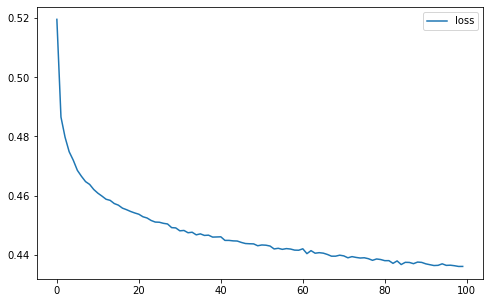

In [360]:
# plot loss evolution
pd.DataFrame(h201.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

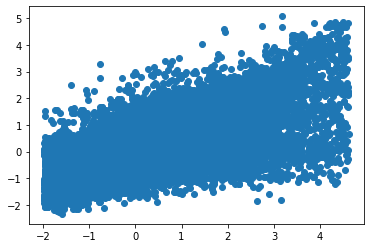

In [361]:
#outliers removed for site_eui and ELEVATION
Y_train_pred = model_NN.predict(X_train)
plt.scatter(Y_train,Y_train_pred)

# Try different neural architechtures

In [364]:
df = train_median_pop.drop('Year_Factor', axis = 1)

In [368]:
x = df.loc[:, df.columns != 'site_eui']
y = df['site_eui']

scaler = StandardScaler()
scaler_x = scaler.fit(x)
x_n = scaler_x.fit_transform(x)
scaler_y = scaler.fit(pd.DataFrame(y))
y_n = scaler_y.fit_transform(pd.DataFrame(y))

print(x_n.shape,y_n.shape)

(75757, 103) (75757, 1)


In [369]:
X_train , X_test, Y_train , Y_test = train_test_split(x_n , y_n, test_size=0.1, random_state=17)
print(X_train.shape,X_test.shape)

(68181, 103) (7576, 103)


In [393]:
# compile a NN with 4 hidden layers, each 20 neurons
#try different architectures
model_NN = Sequential()
n_cols = X_train.shape[1]
print(n_cols)
model_NN.add(Dense(20,activation='relu',input_shape=(n_cols,)))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(20,activation='relu'))
model_NN.add(Dense(1))
#optimizer = keras.optimizer_v2.adam.Adam(0.001)
optimizer = 'adam'
model_NN.compile(optimizer=optimizer,loss='mean_absolute_error')

103


In [394]:
h2000 = model_NN.fit(X_train,Y_train,epochs=100)

Epoch 1/100
68181/68181 [==============================] - 4s 54us/step - loss: 0.4110
Epoch 2/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3856
Epoch 3/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3818
Epoch 4/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3782
Epoch 5/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3757
Epoch 6/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3733
Epoch 7/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3721
Epoch 8/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3705
Epoch 9/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3692
Epoch 10/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3684
Epoch 11/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3676
Epoch 12/100
68181/68181 [===============

68181/68181 [==============================] - 3s 46us/step - loss: 0.3469
Epoch 95/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3471
Epoch 96/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3463
Epoch 97/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3467
Epoch 98/100
68181/68181 [==============================] - 3s 47us/step - loss: 0.3466
Epoch 99/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3465
Epoch 100/100
68181/68181 [==============================] - 3s 46us/step - loss: 0.3464


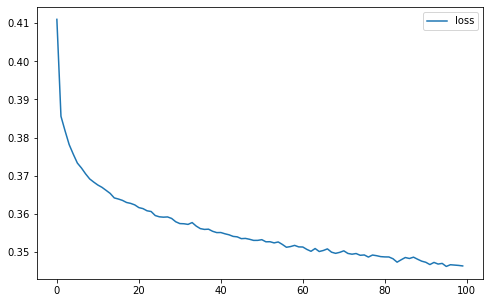

In [395]:
# plot loss evolution
pd.DataFrame(h2000.history).plot(figsize=(8, 5))
# plt.gca().set_ylim(0, 1) 
plt.show()

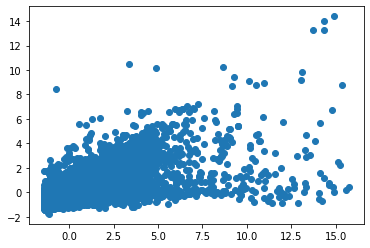

In [396]:
#outliers removed for site_eui and ELEVATION
Y_train_pred = model_NN.predict(X_train)
plt.scatter(Y_train,Y_train_pred)